**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**

# Exercise 3: Deep Learning Practices

In this exercise, you will familiarize yourself with various deep learning practices, including hyper-parameter tuning, regularization, and optimization techniques. You will apply these techniques within the context of a binary classification task designed to classify a given audio file as either speech or music. Please refer to the "ex3_instructions.pdf" file for a complete description of the problem and the applied techniques.

Code Template

To complete this assignment, you will progress through four different stages (tasks):

**Task 1. Basic model architecture, training, and testing loops (5 points)**

**Task 2. Fine-tuning practices (5 points)**

**Task 3. Optimization practices (5 points)**

**Task 4. Regularization practices (5 points)**

### **Deliverables:** 

Please submit the completed notebooks below, along with all the requested trained models (.pth) for the corresponding subtasks.

* ex3_01_base_model.ipynb
* ex3_02_hyperparameter_tuning.ipynb
* ex3_03_optimization.ipynb
* ex3_04_regularization.ipynb
* 'base_model.pth'
* 'relu_model.pth'
* 'lr_model.pth'
* 'shuffle_model.pth'
* 'bs_model.pth'
* 'SGD_model.pth'
* 'normalized_model.pth'
* 'pooled_model.pth'

### **Data**

The dataset used for this exercise consists of a collection of audio .wav files, each with a duration of 5 seconds. You can find and download the data from the Moodle page of the course (Exercise 3). The dataset is provided as a ~150 MB ZIP file on Moodle. Please download the data and extract it into the same folder as the exercise files, naming the folder "dataset_ex3." The "dataset_ex3" folder includes "speech_wav" and "music_wav" folders, each containing audio files for speech and music, respectively.

*Note:* Your dataset path should point to the "dataset_ex3" folder, which contains the "speech" and "music" sub-folders. Be mindful of any extra folder levels that may be created when extracting the "dataset_ex3.zip" file.

After downloading the data and setting up the folders, you are ready to begin the exercise tasks. Let's get started!


## Task 1: Basic Model Design and Training (5 Points)

In this task, you will design and train a basic model for a speech versus music audio classification task. The model takes an audio signal as input and outputs a class label predicting whether the audio signal is speech or music. This exercise uses a convolutional neural network model.

Your task is to design the basic block of the neural model, write a training loop function to train the model for several epochs, and implement a validation function to test the model's performance on the validation set.

### Summary of Tasks for This Stage

**Task 1.1: Design the model architecture** (2 points)

**Task 1.2 & Task 1.3: Complete the training and validation loops** (2 points)

**Successful run of the submitted 'base_model.pth'** (1 point)

### Deliverables from this task:

* ex3_01_base_model.ipynb
* 'base_model.pth'

In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

In [2]:
# Do not delete this cell

Import all necessary libraries.

In [3]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import random

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1) 

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Select the device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Add the data path

In [5]:
path = "dataset_ex3" # you can change the path if you want to store the dataset somewhere else.

In [6]:
# Do not delete this cell

The cell below defines a function for preparing a list of audio file paths from specified directories. It reads .wav files for each class (music and speech), shuffles the data, and splits it into training and validation sets based on the given validation split ratio.

In [7]:
def prepare_file_list(path, validation_split):
    
    audio_class_names = ['music', 'speech']
    data_directories = {'music': path + '/music_wav', 
                        'speech': path + '/speech_wav'}
    
    audio_files = {class_name: [] for class_name in audio_class_names}
    for class_name in audio_class_names:
        folder = data_directories[class_name]
        filelist = os.listdir(folder)
        for filename in filelist:
            if filename.endswith('.wav'):
                audio_files[class_name].append(os.path.join(folder, filename))
       
    np.random.seed(1)
    dataset_split = {'train': [], 'val': []}
    for class_id, class_name in enumerate(audio_class_names):
        n_data = len(audio_files[class_name])
        random_indices = np.random.permutation(n_data)
        n_validation = int(validation_split * n_data)
        val_indices = random_indices[:n_validation]
        train_indices = random_indices[n_validation:]
        dataset_split['train'] += [(audio_files[class_name][k], class_id) for k in train_indices] 
        dataset_split['val'] += [(audio_files[class_name][k], class_id) for k in val_indices] 
    return dataset_split


### Dataset Class

Run the cell below to define the dataset class. The .wav files are read using the "librosa" library. The sample time indicates the duration to sample from each .wav file. The starting point for sampling is set to zero (the beginning of the file) to ensure consistency across different trials.

In [8]:
class MSDataset(torch.utils.data.Dataset):
    
    def __init__(self, filelist, sample_sec=5., is_train=True):
        self.filelist = filelist
        self.time_duration = sample_sec
        self.is_train = is_train
        
        _, sf = librosa.load(filelist[0][0], sr = None)
        self.sf = sf
        self.n_features = int(self.time_duration * sf)
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, i):
        audio_file, class_id = self.filelist[i]
        x, sf = librosa.load(audio_file, sr = None)
        k = 0
            
        x = torch.from_numpy(x[k:k+self.n_features]).reshape(1,-1)
        
        return x, class_id
    

### Task 1.1: Model Architecture

In this task, you will design the model and implement the training and testing loops based on the given instructions.

In the **"MyModel"** template below, which is designed to define the model class, fill in the blanks to complete the model architecture according to the provided instructions. 

The **BasicBlock** class serves as a fundamental building block for constructing convolutional networks. It consists of a convolutional layer followed by a non-linear activation function. 

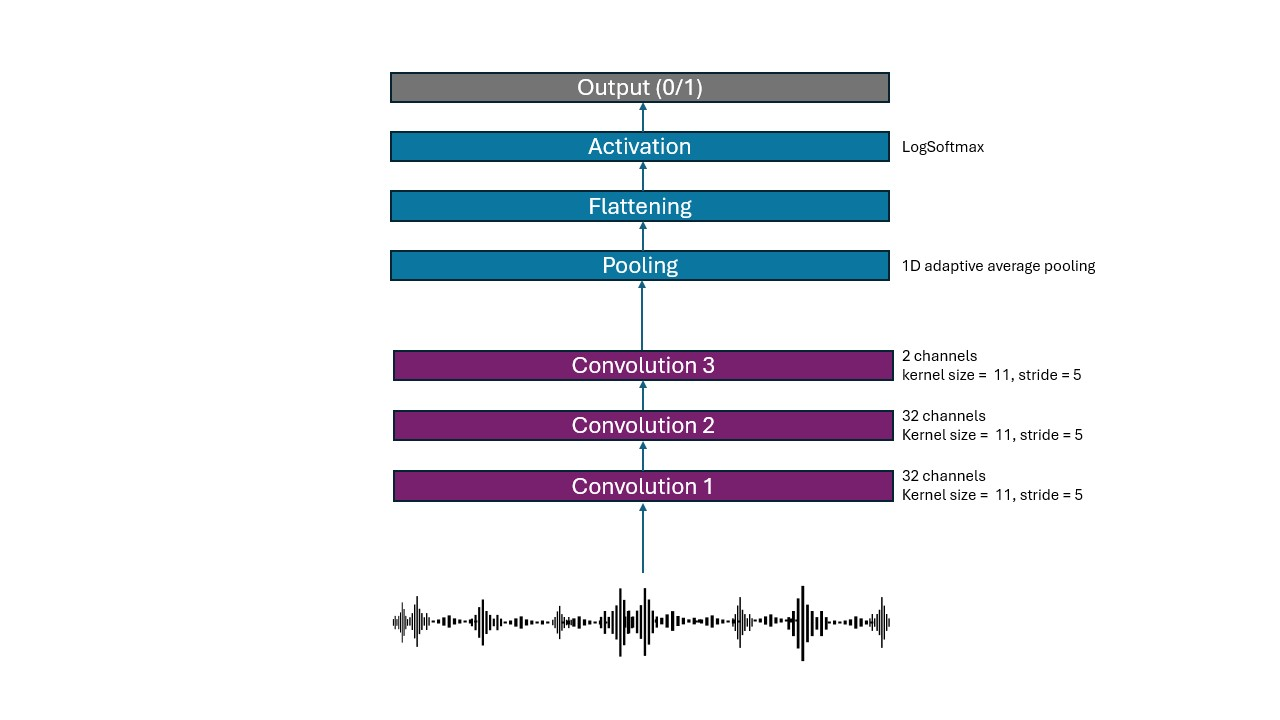

useful links:
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
* https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Input channels: 32 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 4. Create a global average pooling layer to reduce the spatial dimensions
        # 5. Create a flattening layer to flatten the output for the final layer
        # 6. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=32,
                                  out_channels=32,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=32,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Apply global average pooling to reduce dimensions
        # 5. Flatten the pooled output
        # 6. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)

        pooled = self.pool(conv3)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params

Run the cell below to verify the correctness of your solution for the model architecture.

In [10]:
### Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Test the number of Conv1d layers
conv1d_count = sum(1 for layer in model.modules() if isinstance(layer, nn.Conv1d))
if conv1d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 12386
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")


The model has 12386 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Task 1.2 & Task 1.3: Training and Validation Loops

In this task, you will complete the training and validation loops by filling in the blanks according to the provided instructions. The training loop iterates over the dataset to train the model, while the validation loop evaluates the model's performance on a separate validation dataset. The validation loop is called within the training loop to assess the model's accuracy and loss after each training epoch.

In [11]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    np.random.seed(1)
    if hist is not None:
        pass
    else:
        hist = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    best_accuracy = 0
    t_initial = time.time()
    
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, train_accuracy = 0., 0.
        num_samples = 0
        
        for input_batch, target_batch in dl_train: 
            # your code here for minibatch training
            # 1. call batch data and labels and set them to the correct device
            # 2. make the prediction on the data
            # 3. calculate loss
            # 4. set optimizer to zero grad
            # 5. do backward pass
            # 6. move the optimizer one step forward
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)

            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            train_accuracy += (torch.argmax(predictions.detach(), dim=1) == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item() * input_batch.shape[0]
            num_samples += input_batch.shape[0]
        
        train_loss /= num_samples
        train_accuracy /= num_samples       
        val_loss, val_accuracy = validation_loop(model, loss_fn, dl_val)
        
        end = time.time()
        epoch_time = round(end - start, 2)
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, train_loss {train_loss:.2f}, train_accuracy: {train_accuracy:.4f}, '
                   f'val_loss {val_loss:.2f}, val_accuracy: {val_accuracy:.4f}, time = {epoch_time}')

        # record for history return
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss) 
        hist['train_accuracy'].append(train_accuracy)
        hist['val_accuracy'].append(val_accuracy)
        
    t_final = time.time()
    t_total = round(t_final - t_initial, 2)
    minutes = int(t_total // 60)
    seconds = int(t_total % 60)
    print(f'Finished training_loop() within {minutes} minutes and {seconds} seconds')
    return hist

def validation_loop(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, total_accuracy, num_samples = 0., 0., 0.
        
        for input_batch, target_batch in dataloader:
            # your code here for minibatch validation
            # 1. set input_batch, target_batch to correct device
            # 2. make the prediction on input_batch
            # 3. calculate loss and add it to previous loss
            # 4. obtain predicted class labels from predictions (hint: use torch.argmax)
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)
            total_loss += loss_train.item() * input_batch.shape[0]

            predicted_classes = torch.argmax(predictions.detach(), dim=1)
            ###
            
            total_accuracy += (predicted_classes == target_batch).sum().item()
            num_samples += len(target_batch)
    
    average_loss = total_loss / num_samples
    average_accuracy = total_accuracy / num_samples
    
    return average_loss, average_accuracy

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].set_title('Loss')
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Validation')
    axes[0].legend()

    max_val_accuracy = max(history['val_accuracy'])
    axes[1].set_title(f'Accuracy (Best: {max_val_accuracy:.2f})')
    axes[1].plot(history['train_accuracy'], label='Train')
    axes[1].plot(history['val_accuracy'], label='Validation')
    axes[1].legend()


Run the below cell to check the correctness of your solution for the training loop.

In [12]:
# This cell tests the training code
all_tests_successful = True

model = MyModel("Tanh").to(device) 
dummy_optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
dummy_loss_fn = nn.CrossEntropyLoss()

# Create TensorDataset and DataLoader
dummy_inputs = torch.rand(2, 1, 22000).to(device)  
dummy_labels = torch.randint(0, 2, (2,)).to(device) 
dummy_dataset = torch.utils.data.TensorDataset(dummy_inputs, dummy_labels)
dummy_dl_train = torch.utils.data.DataLoader(dummy_dataset, batch_size=2)  
dummy_dl_val = torch.utils.data.DataLoader(dummy_dataset, batch_size=8)

from unittest.mock import patch, MagicMock

with patch('torch.Tensor.backward') as mock_backward, patch.object(dummy_optim, 'step') as mock_step:
    training_loop(1, dummy_optim, model, dummy_loss_fn, dummy_dl_train, dummy_dl_val, hist=None)
    
    if mock_backward.called:   # check if .backward() was called
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to calculate the gradients.")

    if mock_step.called: # check if .step() is used
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to update the weights.")
    
if all_tests_successful:
    success_str = 'Good job! you can now proceed to train your model.'
    print(f"\033[92m{success_str}\033[0m")

Epoch 1, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.02
Finished training_loop() within 0 minutes and 0 seconds
Good job! you can now proceed to train your model.


### Train and Validate 

Run the cell below to train the model with the following setup:

* batch_size = 8
* non_linearity = "Tanh"
* Adam optimizer with learning_rate = 0.0001

We will refer to this model as the "base_model." The code will save the model. You are required to submit the trained "basic_model.pth" along with the notebook file to Moodle.

The model has 12386 trainable parameters.
Epoch 1, train_loss 0.72, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 1.23
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 0.87
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.04
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.95
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.91
Epoch 10, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.94
Epoch 20, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.83
Epoch 30, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 1.07
Epoch 40, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 0.76
Epoch 50, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.6

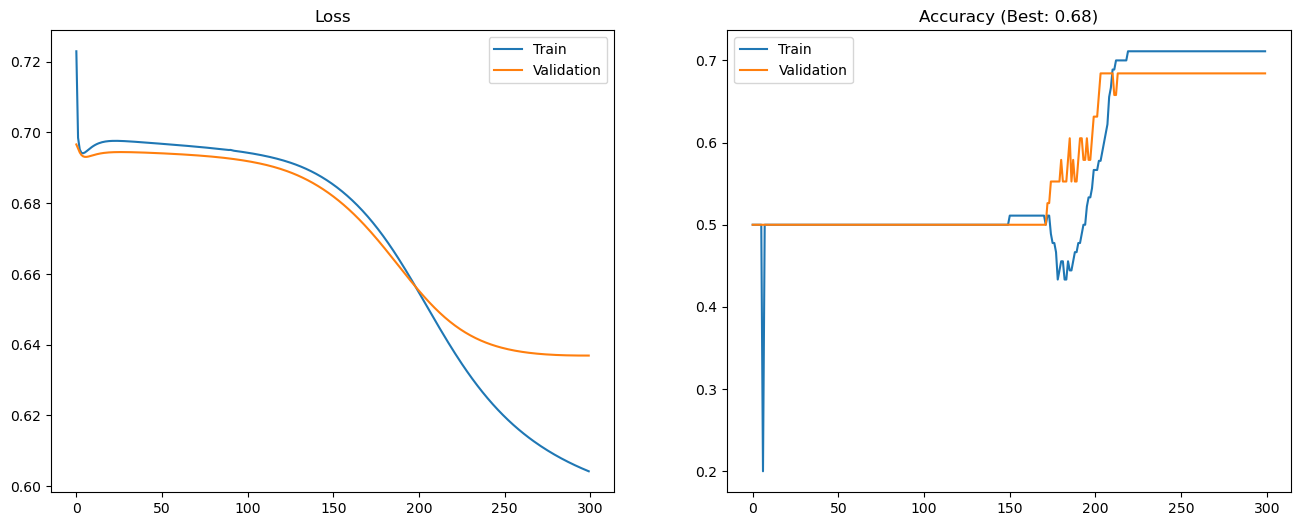

In [13]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("Tanh").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'base_model.pth')
    plot_history(history)
else:
    model = MyModel("Tanh").to(device)
    model.load_state_dict(torch.load('base_model.pth', weights_only=True))
    val_loss, val_acc = validation_loop(model, criterion, data_loader['val'])
    print(f'val_loss {val_loss:.2f}, val_acc {val_acc:.2f}')

Run the below cell to check correctness of your solution for the training and validation performance.

In [14]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:
    
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(history['train_accuracy'])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.5, 1].")
            
        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(history['val_accuracy'])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.5, 1].")
    
        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")
    
    except AssertionError as e:
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")


All visible tests for training and validation accuracy passed successfully!


In [ ]:
# Do not delete this cell